## Description

Сделать проект по классификации наличия святого Георгия на изображении. В папке есть два файла со списком картинок: Георгиев и не Георгиев. Нужно сделать jupyter notebook, в котором будет обучаться модель классификации Георгиев и не Георгиев.

Скачать файлы можно при помощи wget: `wget --random-wait -i filename.txt`. Ссылка на папку для копирования: https://drive.google.com/drive/folders/1hXAjwpBj6shfWd1taWMFpSqelFCzi6KJ?usp=sharing

#### Метрика:
- Accuracy

#### Публичность и переиспользование:
- У всех ячеек с открытием картинок должен быть удален output, чтобы не нарушать ничьих прав.

In [2]:
import os

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.metrics import classification_report

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
tf.__version__

'2.4.1'

## Downloading & reading

In [5]:
# Reading csv with removing duplicates:
source_g = pd.read_csv('georges.csv', header=None, names=['url']).drop_duplicates(subset=['url'], keep=False)
source_ng = pd.read_csv('non_georges.csv', header=None, names=['url']).drop_duplicates(subset=['url'], keep=False)

In [6]:
source_g.head()

,url
1,https://i.pinimg.com/736x/47/b9/9a/47b99a2ddcd...
2,https://i.pinimg.com/736x/90/e8/90/90e890f054b...
3,https://i.pinimg.com/736x/0a/71/6f/0a716f6f14e...
4,https://i.pinimg.com/736x/f1/95/be/f195bea0b78...
5,https://i.pinimg.com/736x/78/da/54/78da54b8fa9...


In [7]:
print('Количество изображений с Георгием: {}\nКоличество изображений без Георгия: {}'.format(len(source_g),
                                                                                             len(source_ng)))

Количество изображений с Георгием: 2092
Количество изображений без Георгия: 3314


In [8]:
# Index equation:
source_ng = source_ng.iloc[:len(source_g), :]
len(source_ng)

2092

In [9]:
# Lists with sources & class names:
source_list = [source_g, source_ng]
label_list = ['georges', 'non_georges']

In [10]:
def get_download(sources, names, test_size):
    
    # Current directory:
    directory = os.getcwd()
    
    # Lists with dir-names:
    dir_list = []
    dir_train_test = []
    
    for dir_1 in ['train_data', 'test_data']:
        dir_train_test.append(os.path.join(directory, dir_1))
        for dir_2 in names:
            dir_list.append(os.path.join(directory, dir_1, dir_2))
            
    # Downloading:
    test_split_idx = round(len(sources[0])*test_size)
    splitted_sources = [sources[0].loc[test_split_idx:, 'url'],
                        sources[1].loc[test_split_idx:, 'url'],
                        sources[0].loc[:test_split_idx, 'url'],
                        sources[1].loc[:test_split_idx, 'url']]
    
    for dir_name, source in zip(dir_list, splitted_sources):
        source.apply(lambda x: tf.keras.utils.get_file(x.split('/')[-1],
                                                       origin=x,
                                                       extract=False,
                                                       cache_subdir=dir_name))
    
    return dir_train_test

In [ ]:
# Start downloading:
train_dir, test_dir = get_download(source_list, label_list, 0.25)

In [11]:
# If data already downloaded with previous function:
train_dir, test_dir = [os.path.join(os.getcwd(), x) for x in ['train_data', 'test_data']]

## Model creating

In [21]:
# Batch & img sizes:
BATCH_SIZE = 150
IMG_SIZE = 250

In [106]:
model = tf.keras.models.Sequential()

# Block 1:
model.add(tf.keras.layers.Convolution2D(64, 3, 3,
                                        input_shape = (IMG_SIZE, IMG_SIZE, 3),
                                        activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
model.add(tf.keras.layers.Dropout(0.1))

# Block 2:
model.add(tf.keras.layers.Convolution2D(64, 3, 3,
                                        activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
model.add(tf.keras.layers.Dropout(0.1))

# Block 3:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.7))

model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

# Model compilation:
model.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [107]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 83, 83, 64)        1792      
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 41, 41, 64)        0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 41, 41, 64)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_59 (Dropout)         (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 2304)            

In [108]:
# Augmentations:
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     #featurewise_center=True,
                                     #featurewise_std_normalization=True,
                                     rotation_range=40, # Поворот на заданный угол
                                     #width_shift_range=0.2, # Диапазон сдвига по ширине (до 20%)
                                     #height_shift_range=0.2, # Диапазон сдвига по высоте (до 20%)
                                     #shear_range=0.2, # Диапазон среза/сдвига (до 20%)
                                     #zoom_range=0.25, # Диапазон увеличения (до 20%)
                                     horizontal_flip=True, # Отражение по горизонтали
                                     fill_mode='nearest')

image_gen_test = ImageDataGenerator(rescale=1./255)

# Generator fot train data:
train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SIZE, IMG_SIZE),
                                                     class_mode='binary',
                                                     interpolation="bicubic")
# Generator fot test data:
test_data_gen = image_gen_test.flow_from_directory(batch_size=BATCH_SIZE,
                                                   directory=test_dir,
                                                   target_size=(IMG_SIZE, IMG_SIZE),
                                                   class_mode='binary',
                                                   interpolation="bicubic")

Found 3138 images belonging to 2 classes.
Found 1046 images belonging to 2 classes.


In [15]:
# Func to plot imgs:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [112]:
temp = [train_data_gen[0][0][0] for x in range(10)]
plotImages(temp)

## Training

In [109]:
# Stop when loss does not decrease:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               verbose=0,
                               mode='min')

# Save the model after every epoch:
checkpointer = ModelCheckpoint(filepath='best_model.h5',
                               verbose=1,
                               save_best_only=True)
# Let`s go:
EPOCHS = 40

history = model.fit_generator(train_data_gen,
                              steps_per_epoch=int(np.ceil(round(len(source_g)*0.75) / float(BATCH_SIZE))),
                              epochs=EPOCHS,
                              callbacks=[checkpointer, early_stopping],
                              validation_data=test_data_gen,
                              validation_steps=int(np.ceil(round(len(source_g)*0.25) / float(BATCH_SIZE))),
                              use_multiprocessing=False)

Epoch 1/40
11/11 [==============================] - 95s 9s/step - loss: 0.6888 - accuracy: 0.5459 - val_loss: 0.6625 - val_accuracy: 0.6433

Epoch 00001: val_loss improved from inf to 0.66254, saving model to best_model.h5
Epoch 2/40
11/11 [==============================] - 89s 8s/step - loss: 0.6276 - accuracy: 0.6468 - val_loss: 0.6184 - val_accuracy: 0.6783

Epoch 00002: val_loss improved from 0.66254 to 0.61841, saving model to best_model.h5
Epoch 3/40
11/11 [==============================] - 90s 8s/step - loss: 0.6175 - accuracy: 0.6573 - val_loss: 0.6241 - val_accuracy: 0.6417

Epoch 00003: val_loss did not improve from 0.61841
Epoch 4/40
11/11 [==============================] - 89s 8s/step - loss: 0.6086 - accuracy: 0.6638 - val_loss: 0.6294 - val_accuracy: 0.6300

Epoch 00004: val_loss did not improve from 0.61841
Epoch 5/40
11/11 [==============================] - 89s 8s/step - loss: 0.5969 - accuracy: 0.6620 - val_loss: 0.6187 - val_accuracy: 0.6617

Epoch 00005: val_loss did


Epoch 00040: val_loss did not improve from 0.47486


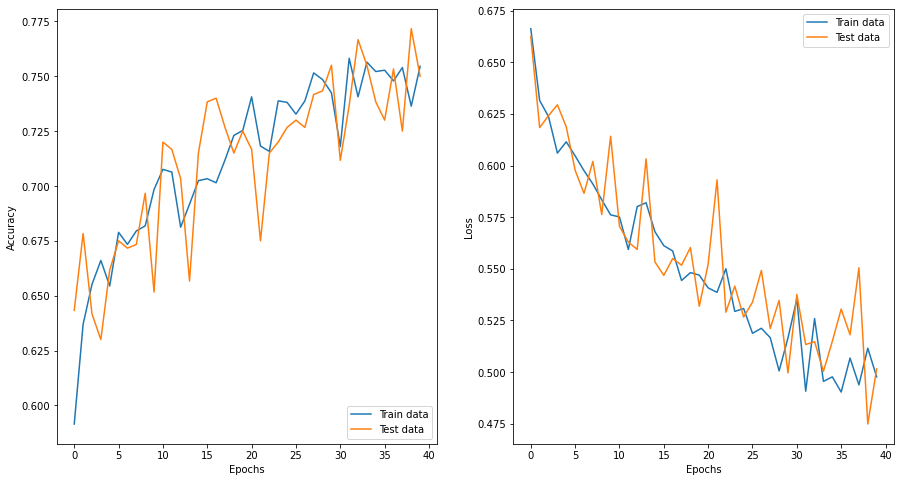

In [196]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train data')
plt.plot(epochs_range, val_acc, label='Test data')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train data')
plt.plot(epochs_range, val_loss, label='Test data')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.savefig('./foo.png')
plt.show()

## Predictions

In [188]:
# Data downloading for predictions:
def load_image(img_path, show=True):
    #imread = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.load_img(img_path,
                                                target_size=(IMG_SIZE, IMG_SIZE),
                                                interpolation='bicubic')
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)
    img_tensor = np.array([img_tensor])
    #img_tensor /= 255.
    
    return img_tensor

In [203]:
# File-lists for predictions:
test_g = os.listdir(os.path.join(test_dir, label_list[0]))
test_ng = os.listdir(os.path.join(test_dir, label_list[1]))

In [215]:
# Get predictions:
g_pred = [round(model.predict(g)[0][0]) for g in
          [load_image(os.path.join(test_dir, label_list[0], x)) for x in test_g]
         ]
ng_pred = [round(model.predict(g)[0][0]) for g in
           [load_image(os.path.join(test_dir, label_list[1], x)) for x in test_ng]
          ]

# Get true classes:
g_true = [0 for g in range(len(test_g))]
ng_true = [1 for ng in range(len(test_ng))]

In [224]:
print(classification_report(g_true+ng_true,
                            g_pred+ng_pred,
                            target_names=['george', 'non_george']))

              precision    recall  f1-score   support

      george       0.84      0.28      0.42       523
  non_george       0.57      0.95      0.71       523

    accuracy                           0.61      1046
   macro avg       0.70      0.61      0.57      1046
weighted avg       0.70      0.61      0.57      1046

